# Online music store data analysis with SQLite
In this project I am working on data from an fictional online music store named Chinook. The data is made by [dataquest.io](www.dataquest.io). The database has several different tables which can be seen with their corresponding columns in the following schema. The black lines between the tables are indicating the connecting columns. 

![database schema](database_schema.png) 

### Creating helper function
I will create three helper function to run queries and show the available tables faster.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm


%matplotlib inline
db = 'chinook.db'

In [2]:
# Function that takes an query and returns pandas dataframe
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql_query(q, conn)

In [3]:
# Function to return list of all tables in the database
def show_tables():
    query = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    return run_query(query)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
# Function for sql queries which do not return tables like create view
def run_command(command):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(command)

# Which genres sell best in the USA?

In [5]:
run_query("Select * from track limit 2")

,track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99


In [6]:
q = '''
WITH total_sale AS (SELECT SUM(il.quantity) as totalsale
    FROM invoice as i
    INNER JOIN invoice_line as il ON il.invoice_id = i.invoice_id
    WHERE billing_country = "USA" )
SELECT 
    g.name as genre,
    SUM(il.quantity) as number_sold,
    CAST(SUM(il.quantity) as FLOAT) / (SELECT totalsale FROM total_sale) as percentage_sold
    
FROM invoice as i
INNER JOIN invoice_line as il ON il.invoice_id = i.invoice_id
INNER JOIN track as t ON t.track_id = il.track_id
INNER JOIN genre as g ON g.genre_id = t.genre_id
WHERE i.billing_country = "USA"
GROUP BY g.name
ORDER BY number_sold DESC'''

genre_sales_number_usa = run_query(q)
run_query(q)

,genre,number_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


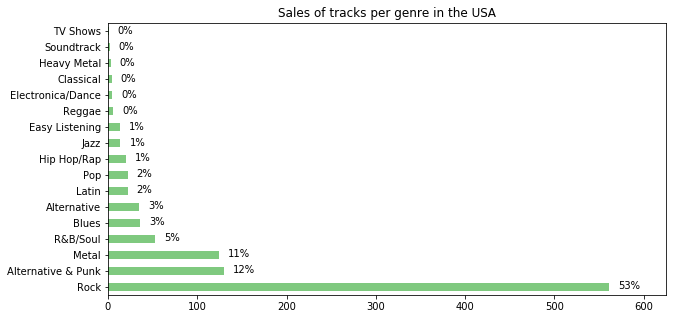

In [7]:
fig = plt.figure(figsize =(10,5))
genre_sales_usa = genre_sales_number_usa.set_index("genre")
genre_sales_usa["number_sold"].plot(kind = "barh", 
                                    title = "Sales of tracks per genre in the USA",
                                    colormap = plt.cm.Accent, xlim = (0, 625))
plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "number_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

**The most sold genre at the Cinook music store is Rock, which counts up to 53% of all sales.**

## Sales performence per employee
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Therefore it can be analysed if some employees performing better or worse than others. 

In [8]:
# First look at the employee table
q = '''
SELECT *
FROM employee
LIMIT 5'''
run_query(q)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


In [9]:
q = '''
SELECT 
    e.first_name || " " || e.last_name as employee_name,
    SUM(i.total) as total_sale,
    e.hire_date,
    e.title,
    2019 - e.birthdate as age
    
FROM employee as e
INNER JOIN customer as c ON c.support_rep_id = e.employee_id
INNER JOIN invoice as i ON i.customer_id = c.customer_id
GROUP BY employee_id
ORDER BY total_sale DESC'''
sales_employee = run_query(q)
run_query(q)

,employee_name,total_sale,hire_date,title,age
0,Jane Peacock,1731.51,2017-04-01 00:00:00,Sales Support Agent,46
1,Margaret Park,1584.00,2017-05-03 00:00:00,Sales Support Agent,72
2,Steve Johnson,1393.92,2017-10-17 00:00:00,Sales Support Agent,54


In [10]:
sales_employee = sales_employee.set_index("employee_name")

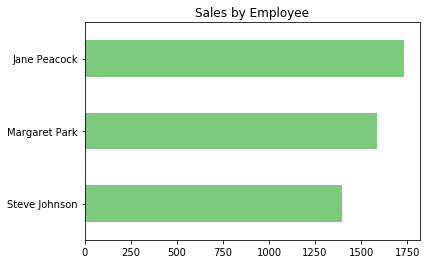

In [11]:
sales_employee.sort_values("total_sale", inplace=True)
sales_employee["total_sale"].plot(kind = "barh", 
                                  legend = False,
                                  title = "Sales by Employee",
                                  colormap = plt.cm.Accent)
plt.ylabel("")
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates

## Sales per country
I will have a look on the total amount of customers per country, the total value of sales, the average value of sales per customers and the average order value.

In [12]:
p = '''
SELECT *,
    CASE
        WHEN c.country_number <= 1 THEN "Other"
        ELSE c.country
    END AS country
FROM (
    SELECT 
        COUNT(c.customer_id) as number_of_customers,
        COUNT(i.total) as sales,
        SUM(i.total) / COUNT(c.customer_id) as average_sales_per_customers,
        COUNT(i.total) / COUNT(i.invoice_id)
    FROM customer as c
    INNER JOIN invoice as i ON i.customer_id = c.customer_id
    GROUP BY c.country)
INNER JOIN invoice as i ON i.customer_id = c.customer_id

'''

In [13]:
p = '''
WITH country_other AS (
    SELECT c.country,
            CASE 
                WHEN COUNT(DISTINCT(c.customer_id)) = 1 THEN "Other"
                ELSE c.country 
            END as country_other
    FROM customer as c
    GROUP BY c.country)

SELECT 
    country,
    number_of_customers,
    total_sales,
    average_sales_per_customers,
    average_order_value
    FROM (SELECT 
        o.country_other as country,
        COUNT(DISTINCT(c.customer_id)) as number_of_customers,
        SUM(i.total) as total_sales,
        SUM(i.total) / COUNT(DISTINCT(c.customer_id)) as average_sales_per_customers,
        SUM(i.total) / COUNT(i.invoice_id) as average_order_value,
        CASE
            WHEN country_other = "Other" THEN 1
            ELSE 0
        END as sort  
    FROM customer as c
    INNER JOIN invoice as i ON i.customer_id = c.customer_id
    LEFT JOIN (SELECT * FROM country_other) as o ON o.country = c.country
    GROUP BY o.country_other
    ORDER BY sort, total_sales DESC)
  '''
sales_by_country = run_query(p)
run_query(p)

,country,number_of_customers,total_sales,average_sales_per_customers,average_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


## Visualizing Sales by Country

In [14]:
import numpy as np
country_metrics = sales_by_country
country_metrics.set_index("country", drop=True, inplace=True)

In [19]:
for i in plt.cm.Accent:
    print(i)

TypeError: 'ListedColormap' object is not iterable

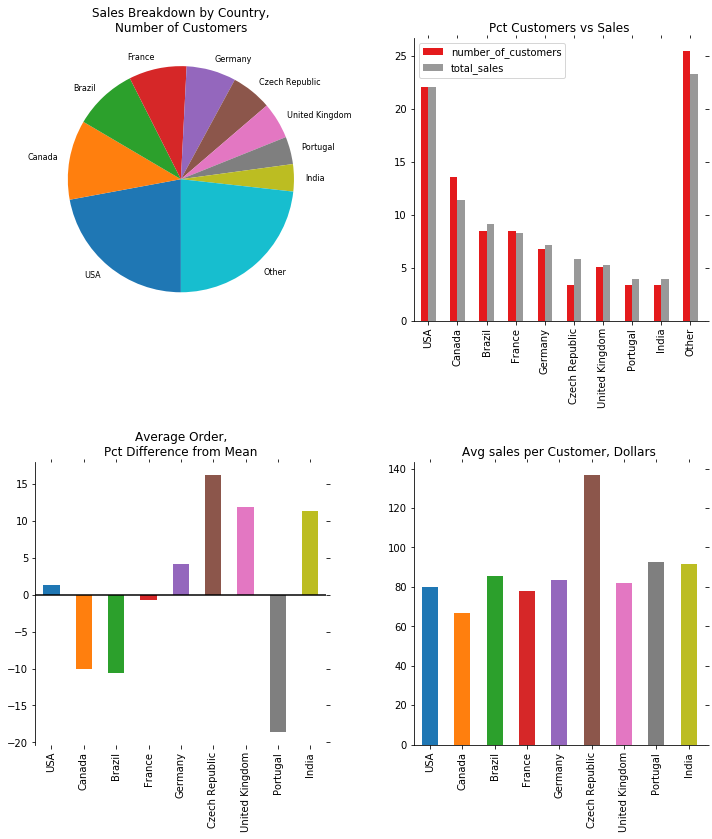

In [20]:
colors = [plt.cm.tab10(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 13))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.tab10,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["number_of_customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["average_sales_per_customers"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Avg sales per Customer, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, the best countries to invest more to expand the buisness would be:

* Czech Republic
* United Kingdom
* India


## Albums vs Individual Tracks
The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

In [16]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


More than 80% of sales are single tracks purchases and only 19% purchases the whole album.

Further ideas for analysing the data a bit more:
* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?
